In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv("df_train_shuffled(2).csv")
df_noise = pd.read_csv("data/cf_train.csv")

In [6]:
def encode(value, encoding):
    for key, val in encoding.items():
        if value == key:
            return val

class_values_era = list(df.era.unique())
class_values_era.sort()
class_values_target = list(df.target_10_val.unique())
class_values_target.sort()
era_encoding = {val: i for i, val in enumerate(class_values_era)}
target_encoding = {val: i for i, val in enumerate(class_values_target)}
df["era"] = df["era"].apply(encode, args=(era_encoding,))
df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))

df_noise["era"] = df_noise["era"].apply(encode, args=(era_encoding,))
df_noise["target_5_val"] = df_noise["target_5_val"].apply(encode, args=(target_encoding,))
df_noise["target_10_val"] = df_noise["target_10_val"].apply(encode, args=(target_encoding,))

dataset = df
target_column = "target_10_val"
output_classes = 5
shuffle = True

In [4]:
dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,High_n-Low_n_changelen_val,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,era,target_10_val,target_5_val
0,0.75,0.75,0.75,0.75,0.25,1.00,1.00,0.50,0.25,0.25,...,0.75,0.25,0.50,0.75,1.00,0.50,100,118,3,2
1,0.25,0.25,0.25,0.25,0.25,0.50,0.75,0.00,0.25,1.00,...,0.00,0.50,1.00,1.00,0.75,0.75,24,4,2,1
2,0.75,0.75,0.75,0.50,0.50,0.50,0.25,1.00,0.75,1.00,...,0.50,0.50,0.25,0.50,0.50,0.50,83,57,2,2
3,0.25,0.25,0.25,0.25,0.75,0.25,0.25,0.75,0.50,0.00,...,0.50,0.25,0.25,1.00,0.75,1.00,101,109,4,3
4,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.25,0.50,1.00,...,0.75,0.50,0.00,0.00,0.50,0.50,101,92,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175122,0.75,0.75,0.75,0.75,0.75,1.00,1.00,0.00,0.75,1.00,...,0.75,0.50,1.00,0.00,0.00,0.00,31,37,2,2
175123,0.75,0.75,0.75,0.75,0.75,0.25,0.00,1.00,0.75,1.00,...,0.00,0.25,0.25,0.25,0.25,0.25,79,131,2,2
175124,0.50,0.50,0.50,0.50,0.00,0.50,0.25,0.75,0.00,0.25,...,0.50,0.25,0.00,0.25,1.00,0.75,65,118,2,3
175125,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.50,0.75,...,0.75,0.50,0.25,0.50,0.50,0.50,115,19,2,3


In [5]:
# remove target_5_val, sigma from the dataset
new_dataset = dataset.drop(columns=["target_5_val"])
era = new_dataset.pop("era")
target = new_dataset.pop(target_column)
new_dataset[target_column] = target
new_dataset["era"] = era
new_dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Close_n_changelen_val,High_n-Low_n_changelen_val,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,target_10_val,era
0,0.75,0.75,0.75,0.75,0.25,1.00,1.00,0.50,0.25,0.25,...,1.00,0.75,0.25,0.50,0.75,1.00,0.50,100,3,118
1,0.25,0.25,0.25,0.25,0.25,0.50,0.75,0.00,0.25,1.00,...,0.25,0.00,0.50,1.00,1.00,0.75,0.75,24,2,4
2,0.75,0.75,0.75,0.50,0.50,0.50,0.25,1.00,0.75,1.00,...,0.50,0.50,0.50,0.25,0.50,0.50,0.50,83,2,57
3,0.25,0.25,0.25,0.25,0.75,0.25,0.25,0.75,0.50,0.00,...,1.00,0.50,0.25,0.25,1.00,0.75,1.00,101,4,109
4,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.25,0.50,1.00,...,0.50,0.75,0.50,0.00,0.00,0.50,0.50,101,2,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175122,0.75,0.75,0.75,0.75,0.75,1.00,1.00,0.00,0.75,1.00,...,0.00,0.75,0.50,1.00,0.00,0.00,0.00,31,2,37
175123,0.75,0.75,0.75,0.75,0.75,0.25,0.00,1.00,0.75,1.00,...,0.25,0.00,0.25,0.25,0.25,0.25,0.25,79,2,131
175124,0.50,0.50,0.50,0.50,0.00,0.50,0.25,0.75,0.00,0.25,...,0.75,0.50,0.25,0.00,0.25,1.00,0.75,65,2,118
175125,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.50,0.75,...,0.50,0.75,0.50,0.25,0.50,0.50,0.50,115,2,19


In [2]:
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X =X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num']).values, new_dataset[target_column].values)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=shuffle)

In [8]:
# load test_data
df_test = pd.read_csv("data/cf_test_no_noise.csv")
df_test_noise = pd.read_csv("data/cf_test.csv")

df_test["era"] = df_test["era"].apply(encode, args=(era_encoding,))
df_test["target_5_val"] = df_test["target_5_val"].apply(encode, args=(target_encoding,))
df_test["target_10_val"] = df_test["target_10_val"].apply(encode, args=(target_encoding,))
df_test_noise["era"] = df_test_noise["era"].apply(encode, args=(era_encoding,))
df_test_noise["target_5_val"] = df_test_noise["target_5_val"].apply(encode, args=(target_encoding,))
df_test_noise["target_10_val"] = df_test_noise["target_10_val"].apply(encode, args=(target_encoding,))

test_set = df_test
target_column = "target_10_val"
output_classes = 5


In [9]:
new_test_dataset= test_set.drop(columns=["target_5_val", "sigma"])
era = new_test_dataset.pop("era")
target = new_test_dataset.pop(target_column)
new_test_dataset[target_column] = target
new_test_dataset["era"] = era
new_test_dataset


,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,day_no,target_10_val,era
0,0.50,0.50,0.50,0.50,0.0,0.75,0.75,0.25,0.25,0.0,...,0.50,1.00,0.50,0.75,0.50,75,555,0,4,NaN
1,0.50,0.50,0.50,0.50,0.0,0.50,0.75,0.25,0.25,0.0,...,0.75,1.00,0.75,0.75,0.75,76,555,0,4,NaN
2,0.50,0.50,0.50,0.50,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.50,0.75,0.75,0.75,77,555,0,4,NaN
3,0.50,0.50,0.50,0.75,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.50,0.75,0.75,0.75,78,555,0,4,NaN
4,0.75,0.75,0.75,0.75,0.0,0.50,0.75,0.50,0.25,0.0,...,0.75,0.25,0.50,0.75,0.75,79,555,0,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.25,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,135,550,959,0,NaN
62396,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.25,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,136,550,959,0,NaN
62397,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.00,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,137,550,959,0,NaN
62398,1.00,1.00,1.00,1.00,0.0,1.00,1.00,0.00,0.25,1.0,...,1.00,1.00,0.00,0.00,0.00,138,550,959,0,NaN


In [10]:
test_dataset = CustomDataset(new_test_dataset.drop(columns=[target_column,'era','row_num','day','day_no']).values, new_test_dataset[target_column].values)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
next(iter(test_loader))

[tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.0000, 0.7500, 0.7500, 0.2500, 0.2500,
          0.0000, 0.7500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.5000,
          0.0000, 0.5000, 1.0000, 0.5000, 0.7500, 0.5000]], dtype=torch.float64),
 tensor([4])]

In [3]:
# define the model
class TTA(nn.Module):
    def __init__(self, input_size, classification_output_size,auxiliary_output_size):
        super(TTA, self).__init__()
        self.NAL_layers = nn.Sequential(
            nn.Linear(classification_output_size, 1),            
        )

        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU()
        )
        self.prediction_branch = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, classification_output_size)
        )
        self.auxiliary_branch = nn.Sequential(
            nn.Linear(64, auxiliary_output_size),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, auxiliary_output_size)
        )
    def forward(self, x):
        x = self.shared_layers(x)
        # get output from second to last layer in prediction branch
        nal_in = self.prediction_branch(x)
        nal_out = torch.sigmoid(self.NAL_layers(nal_in)).to(torch.float64)

        return (self.prediction_branch(x)), self.auxiliary_branch(x), nal_out

class NoiseAttentionLoss(nn.Module):
    def __init__(self, lambda_=50):
        super(NoiseAttentionLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, logits, y, tau):
        y = F.one_hot(y, output_classes).to(torch.float64)
        perceptual = tau.squeeze(1) * (logits.t() - y.t()) + y.t()
        attention_term = torch.matmul(y, torch.log(perceptual + 1e-5))
        attention_term = attention_term.diag()
        boost_term = torch.log(tau + 1e-5) * self.lambda_

        attention_term = -torch.mean(attention_term)
        boost_term = -torch.mean(boost_term)

        return attention_term + boost_term


In [16]:
# train the model on Train data this is not test time training yet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TTA(input_size=24, classification_output_size=5, auxiliary_output_size=24)
model.cuda() 
# classification_criterion = nn.CrossEntropyLoss()
classification_criterion = NoiseAttentionLoss()
auxiliary_criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
bagging_percent = 0.9


epochs = 20
losses = []
predictions = []
accuracy = []
for epoch in tqdm(range(epochs)):
    # loop = tqdm(train_loader, leave=True)
    epoch_acc=[]
    epoch_loss=[]
    for batch,(X, y) in enumerate(train_loader):
        X, y = X.cuda().float(), y.cuda().long()
        
        # # mask 5 columns in X
        # mask = torch.randint(0, 27, (5,))
        # X[:, mask] = 0

        optimizer.zero_grad()
        prediction_logits, auxiliary,tau = model(X)
        # print(tau)
        prediction_softmax = F.softmax(prediction_logits, dim=1).to(torch.float64)
        prediction = torch.argmax(prediction_softmax, dim=1)

        loss1 = classification_criterion(prediction_softmax, y,tau)
        # print(prediction_logits)
        loss2 = auxiliary_criterion(auxiliary, X)
        # print(loss1.item(), loss2.item()    )
        accuracy_batch = (prediction == y).sum().item() / len(y)
        epoch_acc.append(accuracy_batch)

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        epoch_loss.append(loss.item())
        predictions.append(prediction)
        # break
        # if batch == bagging_percent * len(train_loader):
        #     break
    accuracy.append(np.mean(epoch_acc))
    losses.append(np.mean(epoch_loss))
    print(f"Epoch {epoch} Loss: {np.mean(epoch_loss)} Accuracy: {np.mean(epoch_acc)}")



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss: 10.34971768652352 Accuracy: 0.20620388368771816
Epoch 1 Loss: 2.620767365687869 Accuracy: 0.21670079934941286
Epoch 2 Loss: 2.4781060167299236 Accuracy: 0.2338114388289432
Epoch 3 Loss: 2.4516293424396602 Accuracy: 0.2404169807204062
Epoch 4 Loss: 2.4219000846446628 Accuracy: 0.24263527451602665
Epoch 5 Loss: 2.4047906183552885 Accuracy: 0.24324048913043478
Epoch 6 Loss: 2.3988896388811938 Accuracy: 0.243423714693748
Epoch 7 Loss: 2.393595149614829 Accuracy: 0.24454290304665188
Epoch 8 Loss: 2.389062963934018 Accuracy: 0.2464624325610917
Epoch 9 Loss: 2.383708967260806 Accuracy: 0.24900230085687083
Epoch 10 Loss: 2.3810343060603727 Accuracy: 0.25098827753094255
Epoch 11 Loss: 2.3786501006915857 Accuracy: 0.25580470485560136
Epoch 12 Loss: 2.377344334979839 Accuracy: 0.26145370517296096
Epoch 13 Loss: 2.3745540359758848 Accuracy: 0.2678876745477626
Epoch 14 Loss: 2.371615406908829 Accuracy: 0.2707682085052364
Epoch 15 Loss: 2.3643838219490942 Accuracy: 0.2775606950174548
E

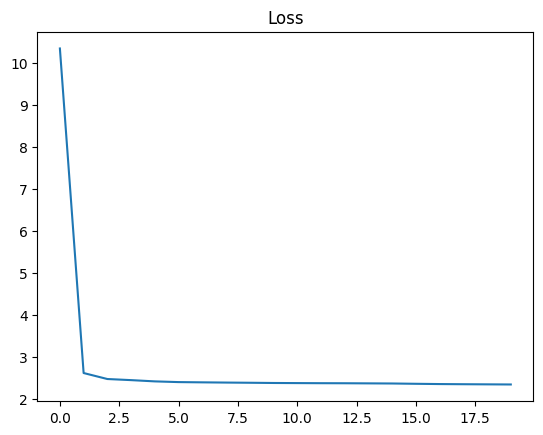

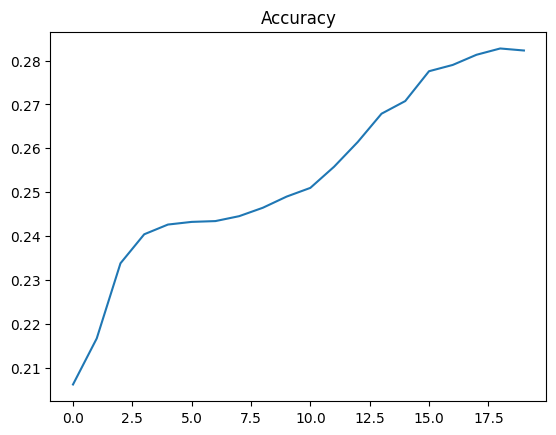

In [17]:
#plot the loss and accuracy
plt.plot(losses)
plt.title("Loss")
plt.show()

plt.plot(accuracy)
plt.title("Accuracy")
plt.show()



In [42]:
# test_accuracies = []
# all_prediction_logits = []
# for batch, (X,y) in tqdm(enumerate((test_loader))):
#     optimizer.zero_grad()
#     X, y = X,y
#     X,y= X.cuda().float(), y.cuda().long()


#     prediction_logits, auxiliary,tau = model(X)

#     aux_loss = auxiliary_criterion(auxiliary, X)
#     loss = aux_loss
#     # print("aux_loss", aux_loss.item())
#     loss.backward()
#     optimizer.step()
    
#     prediction_logits, auxiliary,tau = model(X)
#     prediction = F.softmax(prediction_logits, dim=1)
#     prediction = torch.argmax(prediction, dim=1)
#     all_prediction_logits.extend(prediction)
#     batch_accuracy = (prediction == y).sum().item() / len(y)
#     test_accuracies.append(batch_accuracy)

# print(f"Test Accuracy: {np.mean(test_accuracies)}")



Test Accuracy: 0.6081730769230769


In [43]:
# test_accuracies

[1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

# Live Dataset (All datasets combined)

In [23]:
folder_path = 'live_data/live_data_02-Apr-2024'
''' 
the folder path has 2 types of files - df_live_test and df_live_train
Concatenate the files and save it as a single file
'''
# sort the files in increasing order of file name length
def sort_files(folder_path):
    files = os.listdir(folder_path)
    files.sort(key=len)
    return files

def concat_files(folder_path):
    df_test_list = pd.DataFrame()
    df_train = pd.DataFrame()

    files = sort_files(folder_path)
    for file in files:
        print(file)
        if file[0:12] == 'df_live_test':
            file_path = os.path.join(folder_path, file)
            df_temp = pd.read_csv(file_path)
            df_test_list = pd.concat([df_test_list, df_temp], axis=0)
        elif file[0:13] == 'df_live_train':
            file_path = os.path.join(folder_path, file)
            df_temp = pd.read_csv(file_path)
            df_train = pd.concat([df_train, df_temp], axis=0)
    return df_test_list, df_train

df_test,df=concat_files(folder_path)

df_live_test_02-Apr-2024_84.csv
df_live_test_02-Apr-2024_85.csv
df_live_test_02-Apr-2024_86.csv
df_live_test_02-Apr-2024_92.csv
df_live_test_02-Apr-2024_93.csv
df_live_test_02-Apr-2024_94.csv
df_live_test_02-Apr-2024_95.csv
df_live_test_02-Apr-2024_96.csv
df_live_test_02-Apr-2024_97.csv
df_live_test_02-Apr-2024_98.csv
df_live_test_02-Apr-2024_99.csv
df_live_test_02-Apr-2024_102.csv
df_live_test_02-Apr-2024_103.csv
df_live_test_02-Apr-2024_104.csv
df_live_test_02-Apr-2024_105.csv
df_live_test_02-Apr-2024_106.csv
df_live_test_02-Apr-2024_107.csv
df_live_test_02-Apr-2024_108.csv
df_live_test_02-Apr-2024_109.csv
df_live_test_02-Apr-2024_110.csv
df_live_test_02-Apr-2024_111.csv
df_live_test_02-Apr-2024_112.csv
df_live_test_02-Apr-2024_113.csv
df_live_test_02-Apr-2024_117.csv
df_live_test_02-Apr-2024_120.csv
df_live_test_02-Apr-2024_121.csv
df_live_test_02-Apr-2024_122.csv
df_live_test_02-Apr-2024_123.csv
df_live_test_02-Apr-2024_124.csv
df_live_test_02-Apr-2024_125.csv
df_live_test_02-Apr-2

In [24]:
df.columns

Index(['Open_n_val', 'High_n_val', 'Low_n_val', 'Close_n_val', 'Volume_n_val',
       'SMA_10_val', 'SMA_20_val', 'CMO_14_val', 'High_n-Low_n_val',
       'Open_n-Close_n_val', 'SMA_20-SMA_10_val', 'Close_n_slope_3_val',
       'Close_n_slope_5_val', 'Close_n_slope_10_val', 'Open_n_changelen_val',
       'High_n_changelen_val', 'Low_n_changelen_val', 'Close_n_changelen_val',
       'High_n-Low_n_changelen_val', 'Open_n-Close_n_changelen_val',
       'SMA_20-SMA_10_changelen_val', 'Close_n_slope_3_changelen_val',
       'Close_n_slope_5_changelen_val', 'Close_n_slope_10_changelen_val',
       'row_num', 'era', 'id', 'target_5_val', 'target_10_val', 'target_5',
       'target_10'],
      dtype='object')

In [25]:
def encode(value, encoding):
    for key, val in encoding.items():
        if value == key:
            return val

class_values_era = list(df.era.unique())
class_values_era.sort()
class_values_target = list(df.target_10_val.unique())
class_values_target.sort()
era_encoding = {val: i for i, val in enumerate(class_values_era)}
target_encoding = {val: i for i, val in enumerate(class_values_target)}
df["era"] = df["era"].apply(encode, args=(era_encoding,))
df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))


dataset = df
target_column = "target_10_val"
output_classes = 5
shuffle = True

In [26]:
new_dataset = dataset.drop(columns=["target_5_val", "target_5","target_10","id"])
era = new_dataset.pop("era")
target = new_dataset.pop(target_column)
new_dataset[target_column] = target
new_dataset["era"] = era
new_dataset

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Close_n_changelen_val,High_n-Low_n_changelen_val,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,target_10_val,era
0,0.0,1.00,0.00,1.00,0.00,1.0,0.75,0.50,1.00,0.00,...,0.50,0.75,0.25,0.50,0.50,0.50,0.50,0,0,0
1,1.0,1.00,0.75,1.00,1.00,1.0,0.75,0.50,0.50,0.50,...,0.75,0.75,0.50,0.50,1.00,0.75,0.75,1,0,0
2,1.0,1.00,0.50,0.75,1.00,1.0,0.75,0.50,1.00,0.75,...,0.25,1.00,0.75,0.75,0.25,0.25,0.25,2,0,0
3,0.5,0.50,0.50,0.50,1.00,1.0,0.75,0.50,1.00,0.75,...,0.00,0.75,0.25,0.75,0.25,0.00,0.25,3,1,0
4,0.5,0.50,0.50,0.75,1.00,1.0,0.75,0.50,0.75,0.00,...,0.75,0.50,0.00,0.75,1.00,0.75,0.75,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.0,0.25,0.00,0.00,0.75,0.0,0.00,0.00,0.75,0.50,...,0.50,0.75,0.75,0.50,1.00,0.75,0.75,139,2,0
285,0.0,0.00,0.00,0.00,0.25,0.0,0.00,0.00,0.00,0.50,...,0.25,0.50,0.75,0.25,0.50,1.00,0.75,140,2,0
286,0.0,0.00,0.00,0.00,0.50,0.0,0.00,0.00,0.50,0.50,...,0.75,0.75,0.25,0.25,0.75,1.00,0.75,141,2,0
287,0.0,0.00,0.00,0.25,0.50,0.0,0.00,0.25,0.50,0.25,...,1.00,0.50,0.00,0.25,1.00,0.50,0.75,142,2,0


In [27]:
train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num']).values, new_dataset[target_column].values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle)

In [32]:
df_test.columns

Index(['id', 'Open_n_val', 'High_n_val', 'Low_n_val', 'Close_n_val',
       'Volume_n_val', 'SMA_10_val', 'SMA_20_val', 'CMO_14_val',
       'High_n-Low_n_val', 'Open_n-Close_n_val', 'SMA_20-SMA_10_val',
       'Close_n_slope_3_val', 'Close_n_slope_5_val', 'Close_n_slope_10_val',
       'Open_n_changelen_val', 'High_n_changelen_val', 'Low_n_changelen_val',
       'Close_n_changelen_val', 'High_n-Low_n_changelen_val',
       'Open_n-Close_n_changelen_val', 'SMA_20-SMA_10_changelen_val',
       'Close_n_slope_3_changelen_val', 'Close_n_slope_5_changelen_val',
       'Close_n_slope_10_changelen_val', 'row_num'],
      dtype='object')

In [33]:
test_set = df_test
target_column = "row_num"
output_classes = 5

In [34]:
test_dataset = CustomDataset(test_set.drop(columns=[target_column,'row_num','id']).values, new_test_dataset[target_column].values)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [37]:
# test the model on test data
test_accuracies = []
predictions=[]
all_prediction_logits = []

for batch, (X,y) in tqdm(enumerate((test_loader))):
    optimizer.zero_grad()
    X, y = X,y
    X,y= X.cuda().float(), y.cuda().long()
    prediction_logits, auxiliary,tau = model(X)

    aux_loss = auxiliary_criterion(auxiliary, X)
    loss = aux_loss
    # print("aux_loss", aux_loss.item())
    loss.backward()
    optimizer.step()
    
    prediction_logits, auxiliary,tau = model(X)
    prediction = F.softmax(prediction_logits, dim=1)
    prediction = torch.argmax(prediction, dim=1)
    all_prediction_logits.extend(prediction)
    # batch_accuracy = (prediction == y).sum().item() / len(y)
    # test_accuracies.append(batch_accuracy)
    predictions.append(prediction.item())

    if batch == 10:
        break
# print(f"Test Accuracy: {np.mean(test_accuracies)}")




0it [00:00, ?it/s]

In [38]:
predictions

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

# Live Data (Pair of datasets)

In [20]:
folder_path = 'live_data/live_data_08-Apr-2024'
'''
the folder path has 2 types of files - df_live_test and df_live_train
Concatentae the files and save it as a single file
'''
# sort the files in increasing order of file name length
def sort_files(folder_path):
    files = os.listdir(folder_path)
    files.sort(key=len)
    return files


def concat_files(folder_path):
    df_test_list = []
    df_train_list = []

    df_test_list_names = []
    df_train_list_names = []

    files = sort_files(folder_path)
    for file in files:
        # print(file)
        if file[0:12] == 'df_live_test':
            df_test_list_names.append(file)
            file_path = os.path.join(folder_path, file)
            df_temp = pd.read_csv(file_path)
            df_test_list.append(df_temp)
        elif file[0:13] == 'df_live_train':
            df_train_list_names.append(file)
            file_path = os.path.join(folder_path, file)
            df_temp = pd.read_csv(file_path)
            df_train_list.append(df_temp)
    # print(df_test_list_names)
    # print(df_train_list_names)
    # print(len(df_test_list), len(df_train_list))
    return df_test_list, df_train_list

df_test,df_train=concat_files(folder_path)

In [21]:
all_predictions=[]
model = TTA(input_size=24, classification_output_size=5, auxiliary_output_size=24)
model.cuda() 
# classification_criterion = nn.CrossEntropyLoss()
classification_criterion = NoiseAttentionLoss()
auxiliary_criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
bagging_percent = 0.9


for dataset_num in range(len(df_train)):
    print("dataset_num", dataset_num)
    df = df_train[dataset_num]

    class_values_era = list(df.era.unique())
    class_values_era.sort()
    class_values_target = list(df.target_10_val.unique())
    class_values_target.sort()
    era_encoding = {val: i for i, val in enumerate(class_values_era)}
    target_encoding = {val: i for i, val in enumerate(class_values_target)}
    df["era"] = df["era"].apply(encode, args=(era_encoding,))
    df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
    df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))

    dataset = df
    target_column = "target_10_val"
    output_classes = 5
    shuffle = True

    new_dataset = dataset.drop(columns=["target_5_val", "target_5","target_10","id"])
    era = new_dataset.pop("era")
    target = new_dataset.pop(target_column)
    new_dataset[target_column] = target
    new_dataset["era"] = era

    train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num']).values, new_dataset[target_column].values)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle)

    epochs = 5
    losses = []
    predictions = []
    accuracy = []
    for epoch in tqdm(range(epochs)):
        # loop = tqdm(train_loader, leave=True)
        epoch_acc=[]
        epoch_loss=[]
        for batch,(X, y) in enumerate(train_loader):
            X, y = X.cuda().float(), y.cuda().long()
            
            # # mask 5 columns in X
            # mask = torch.randint(0, 27, (5,))
            # X[:, mask] = 0

            optimizer.zero_grad()
            prediction_logits, auxiliary,tau = model(X)
            # print(tau)
            prediction_softmax = F.softmax(prediction_logits, dim=1).to(torch.float64)
            prediction = torch.argmax(prediction_softmax, dim=1)

            loss1 = classification_criterion(prediction_softmax, y,tau)
            # print(prediction_logits)
            loss2 = auxiliary_criterion(auxiliary, X)
            # print(loss1.item(), loss2.item()    )
            accuracy_batch = (prediction == y).sum().item() / len(y)
            epoch_acc.append(accuracy_batch)

            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            # losses.append(loss.item())
            epoch_loss.append(loss.item())
            predictions.append(prediction)
            # break
            # if batch == bagging_percent * len(train_loader):
            #     break
        accuracy.append(np.mean(epoch_acc))
        losses.append(np.mean(epoch_loss))
        print(f"Epoch {epoch} Loss: {np.mean(epoch_loss)} Accuracy: {np.mean(epoch_acc)}")


    df_test_list = df_test[dataset_num]
    target_column = "row_num"
    output_classes = 5

    test_dataset = CustomDataset(df_test_list.drop(columns=[target_column,'row_num','id']).values, df_test_list[target_column].values)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # test the model on test data
    test_accuracies = []
    predictions=[]
    all_prediction_logits = []

    for batch, (X,y) in tqdm(enumerate((test_loader))):
        optimizer.zero_grad()
        X, y = X,y
        X,y= X.cuda().float(), y.cuda().long()
        prediction_logits, auxiliary,tau = model(X)

        aux_loss = auxiliary_criterion(auxiliary, X)
        loss = aux_loss
        # print("aux_loss", aux_loss.item())
        loss.backward()
        optimizer.step()
        
        prediction_logits, auxiliary,tau = model(X)
        prediction = F.softmax(prediction_logits, dim=1)
        prediction = torch.argmax(prediction, dim=1)
        all_prediction_logits.extend(prediction)
        # batch_accuracy = (prediction == y).sum().item() / len(y)
        # test_accuracies.append(batch_accuracy)
        predictions.append(prediction.item())

        if batch == 10:
            break
    all_predictions.append(predictions)
    # print(f"Test Accuracy: {np.mean(test_accuracies)}")

dataset_num 0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 35.764253241749415 Accuracy: 0.12094907407407407
Epoch 1 Loss: 35.70821104286548 Accuracy: 0.11805555555555555
Epoch 2 Loss: 35.65977958229175 Accuracy: 0.12094907407407407
Epoch 3 Loss: 35.60600545657549 Accuracy: 0.11805555555555555
Epoch 4 Loss: 35.55060009906273 Accuracy: 0.11226851851851852


0it [00:00, ?it/s]

dataset_num 1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 35.47948017307574 Accuracy: 0.11607142857142858
Epoch 1 Loss: 35.43066369527094 Accuracy: 0.11830357142857142
Epoch 2 Loss: 35.38011622509997 Accuracy: 0.11607142857142858
Epoch 3 Loss: 35.32907584387395 Accuracy: 0.11160714285714285
Epoch 4 Loss: 35.27713735464905 Accuracy: 0.1517857142857143


0it [00:00, ?it/s]

dataset_num 2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 35.0896122543593 Accuracy: 0.26264880952380953
Epoch 1 Loss: 34.72175777495099 Accuracy: 0.26339285714285715
Epoch 2 Loss: 34.335400610441866 Accuracy: 0.25669642857142855
Epoch 3 Loss: 34.01627924257106 Accuracy: 0.25669642857142855
Epoch 4 Loss: 33.75769986172036 Accuracy: 0.25669642857142855


0it [00:00, ?it/s]

dataset_num 3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 33.45190085536195 Accuracy: 0.2688078703703704
Epoch 1 Loss: 33.12829309188399 Accuracy: 0.26070601851851855
Epoch 2 Loss: 32.69847299524091 Accuracy: 0.26273148148148145
Epoch 3 Loss: 31.991748722152167 Accuracy: 0.2566550925925926
Epoch 4 Loss: 30.907767638972814 Accuracy: 0.26273148148148145


0it [00:00, ?it/s]

dataset_num 4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 29.604419278513028 Accuracy: 0.25375000000000003
Epoch 1 Loss: 28.844803127011517 Accuracy: 0.22625
Epoch 2 Loss: 27.903707599839414 Accuracy: 0.26749999999999996
Epoch 3 Loss: 26.87454387345531 Accuracy: 0.25375000000000003
Epoch 4 Loss: 25.672541045092476 Accuracy: 0.22625


0it [00:00, ?it/s]

dataset_num 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 24.13701955868338 Accuracy: 0.17708333333333334
Epoch 1 Loss: 23.391030761661316 Accuracy: 0.19791666666666666
Epoch 2 Loss: 22.50349423331693 Accuracy: 0.19791666666666666
Epoch 3 Loss: 21.347735720694388 Accuracy: 0.17708333333333334
Epoch 4 Loss: 20.34662809147495 Accuracy: 0.1875


0it [00:00, ?it/s]

dataset_num 6


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 19.617723899510324 Accuracy: 0.286764705882353
Epoch 1 Loss: 18.406398536223715 Accuracy: 0.3235294117647059
Epoch 2 Loss: 17.25671787090163 Accuracy: 0.2959558823529412
Epoch 3 Loss: 16.11025575517435 Accuracy: 0.2959558823529412
Epoch 4 Loss: 14.975208148226947 Accuracy: 0.2959558823529412


0it [00:00, ?it/s]

dataset_num 7


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 14.068415345571294 Accuracy: 0.29050925925925924
Epoch 1 Loss: 13.059160490250996 Accuracy: 0.2986111111111111
Epoch 2 Loss: 11.922466206799902 Accuracy: 0.30671296296296297
Epoch 3 Loss: 11.032257978751403 Accuracy: 0.2824074074074074
Epoch 4 Loss: 10.115343486129953 Accuracy: 0.2986111111111111


0it [00:00, ?it/s]

dataset_num 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 8.682206915857726 Accuracy: 0.2638888888888889
Epoch 1 Loss: 7.438551960074555 Accuracy: 0.21875
Epoch 2 Loss: 6.341340205534899 Accuracy: 0.2638888888888889
Epoch 3 Loss: 5.664206783690271 Accuracy: 0.2638888888888889
Epoch 4 Loss: 5.171914742303243 Accuracy: 0.24131944444444445


0it [00:00, ?it/s]

dataset_num 9


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 4.673316918810396 Accuracy: 0.314484126984127
Epoch 1 Loss: 4.587382615928167 Accuracy: 0.3199404761904762
Epoch 2 Loss: 4.36362158285819 Accuracy: 0.314484126984127
Epoch 3 Loss: 4.372428246668842 Accuracy: 0.2926587301587302
Epoch 4 Loss: 4.221236049435943 Accuracy: 0.3253968253968254


0it [00:00, ?it/s]

In [22]:
all_predictions


[[0],
 [0],
 [3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3],
 [3, 3],
 [3],
 [3],
 [3],
 [3, 3],
 [3]]

In [23]:
# save predictions to a file
import csv
with open('8Apr_predictions.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(all_predictions)

In [16]:
folder_path = 'live_data/live_data_05-Apr-2024'

df_test,df_train=concat_files(folder_path)

all_predictions=[]

In [17]:
for dataset_num in range(len(df_train)):
    print("dataset_num", dataset_num)
    df = df_train[dataset_num]

    class_values_era = list(df.era.unique())
    class_values_era.sort()
    class_values_target = list(df.target_10_val.unique())
    class_values_target.sort()
    era_encoding = {val: i for i, val in enumerate(class_values_era)}
    target_encoding = {val: i for i, val in enumerate(class_values_target)}
    df["era"] = df["era"].apply(encode, args=(era_encoding,))
    df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
    df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))

    dataset = df
    target_column = "target_10_val"
    output_classes = 5
    shuffle = True

    train_dataset = CustomDataset(new_dataset.drop(columns=[target_column,'era','row_num']).values, new_dataset[target_column].values)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle)




    epochs = 5
    losses = []
    predictions = []
    accuracy = []
    for epoch in tqdm(range(epochs)):
        # loop = tqdm(train_loader, leave=True)
        epoch_acc=[]
        epoch_loss=[]
        for batch,(X, y) in enumerate(train_loader):
            X, y = X.cuda().float(), y.cuda().long()
            
            # # mask 5 columns in X
            # mask = torch.randint(0, 27, (5,))
            # X[:, mask] = 0

            optimizer.zero_grad()
            prediction_logits, auxiliary,tau = model(X)
            # print(tau)
            prediction_softmax = F.softmax(prediction_logits, dim=1).to(torch.float64)
            prediction = torch.argmax(prediction_softmax, dim=1)

            loss1 = classification_criterion(prediction_softmax, y,tau)
            # print(prediction_logits)
            loss2 = auxiliary_criterion(auxiliary, X)
            # print(loss1.item(), loss2.item()    )
            accuracy_batch = (prediction == y).sum().item() / len(y)
            epoch_acc.append(accuracy_batch)

            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            # losses.append(loss.item())
            epoch_loss.append(loss.item())
            predictions.append(prediction)
            # break
            # if batch == bagging_percent * len(train_loader):
            #     break
        accuracy.append(np.mean(epoch_acc))
        losses.append(np.mean(epoch_loss))
        print(f"Epoch {epoch} Loss: {np.mean(epoch_loss)} Accuracy: {np.mean(epoch_acc)}")


    df_test_list = df_test[dataset_num]
    target_column = "row_num"
    output_classes = 5

    test_dataset = CustomDataset(df_test_list.drop(columns=[target_column,'row_num','id']).values, df_test_list[target_column].values)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # test the model on test data
    test_accuracies = []
    predictions=[]
    all_prediction_logits = []

    for batch, (X,y) in tqdm(enumerate((test_loader))):
        optimizer.zero_grad()
        X, y = X,y
        X,y= X.cuda().float(), y.cuda().long()
        prediction_logits, auxiliary,tau = model(X)

        aux_loss = auxiliary_criterion(auxiliary, X)
        loss = aux_loss
        # print("aux_loss", aux_loss.item())
        loss.backward()
        optimizer.step()
        
        prediction_logits, auxiliary,tau = model(X)
        prediction = F.softmax(prediction_logits, dim=1)
        prediction = torch.argmax(prediction, dim=1)
        all_prediction_logits.extend(prediction)
        # batch_accuracy = (prediction == y).sum().item() / len(y)
        # test_accuracies.append(batch_accuracy)
        predictions.append(prediction.item())

        if batch == 10:
            break
    all_predictions.append(predictions)
    # print(f"Test Accuracy: {np.mean(test_accuracies)}"

dataset_num 0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.214929055864428 Accuracy: 0.31120770676691734
Epoch 1 Loss: 2.2182095327552713 Accuracy: 0.30157424812030076
Epoch 2 Loss: 2.204700593422939 Accuracy: 0.3202537593984962
Epoch 3 Loss: 2.2102154403569343 Accuracy: 0.32835996240601506
Epoch 4 Loss: 2.2018471969545264 Accuracy: 0.3223684210526316


0it [00:00, ?it/s]

dataset_num 1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.203497348638036 Accuracy: 0.32835996240601506
Epoch 1 Loss: 2.185645286747602 Accuracy: 0.31649436090225563
Epoch 2 Loss: 2.1929362937532333 Accuracy: 0.3105028195488722
Epoch 3 Loss: 2.198766382031054 Accuracy: 0.3403430451127819
Epoch 4 Loss: 2.2113725036266474 Accuracy: 0.31414473684210525


0it [00:00, ?it/s]

dataset_num 2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.184139014196132 Accuracy: 0.3202537593984962
Epoch 1 Loss: 2.1895564459637464 Accuracy: 0.28888627819548873
Epoch 2 Loss: 2.207876581508109 Accuracy: 0.3335291353383459
Epoch 3 Loss: 2.1896363826447343 Accuracy: 0.30968045112781956
Epoch 4 Loss: 2.192962999676383 Accuracy: 0.31778665413533835


0it [00:00, ?it/s]

dataset_num 3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1825100777964765 Accuracy: 0.3246005639097745
Epoch 1 Loss: 2.2214083073757256 Accuracy: 0.2999295112781955
Epoch 2 Loss: 2.174347365309355 Accuracy: 0.2933505639097745
Epoch 3 Loss: 2.164408434883566 Accuracy: 0.33658364661654133
Epoch 4 Loss: 2.1841465009743297 Accuracy: 0.31708176691729323


0it [00:00, ?it/s]

dataset_num 4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1701436121107966 Accuracy: 0.32554041353383456
Epoch 1 Loss: 2.1607182860242764 Accuracy: 0.30991541353383456
Epoch 2 Loss: 2.183658727402833 Accuracy: 0.3075657894736842
Epoch 3 Loss: 2.175092256919081 Accuracy: 0.31414473684210525
Epoch 4 Loss: 2.160529346605323 Accuracy: 0.3059210526315789


0it [00:00, ?it/s]

dataset_num 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.170828030045657 Accuracy: 0.3179041353383459
Epoch 1 Loss: 2.1607077928943537 Accuracy: 0.30838815789473684
Epoch 2 Loss: 2.1602443740243347 Accuracy: 0.321781015037594
Epoch 3 Loss: 2.147678154176353 Accuracy: 0.29699248120300753
Epoch 4 Loss: 2.158146634421969 Accuracy: 0.3402255639097745


0it [00:00, ?it/s]

dataset_num 6


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1469263409374304 Accuracy: 0.32307330827067665
Epoch 1 Loss: 2.1638216985084773 Accuracy: 0.30968045112781956
Epoch 2 Loss: 2.165678381832978 Accuracy: 0.3142622180451128
Epoch 3 Loss: 2.1547134396183725 Accuracy: 0.3261278195488722
Epoch 4 Loss: 2.1354504810078674 Accuracy: 0.32013627819548873


0it [00:00, ?it/s]

dataset_num 7


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.161569025261341 Accuracy: 0.3223684210526316
Epoch 1 Loss: 2.135560915611855 Accuracy: 0.3142622180451128
Epoch 2 Loss: 2.152059706611594 Accuracy: 0.3194313909774436
Epoch 3 Loss: 2.1371653708678364 Accuracy: 0.33670112781954886
Epoch 4 Loss: 2.152288225883005 Accuracy: 0.2926456766917293


0it [00:00, ?it/s]

dataset_num 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1314382329177093 Accuracy: 0.3202537593984962
Epoch 1 Loss: 2.1416687659149103 Accuracy: 0.30979793233082703
Epoch 2 Loss: 2.1464970909448575 Accuracy: 0.3089755639097745
Epoch 3 Loss: 2.1548789478067953 Accuracy: 0.32248590225563906
Epoch 4 Loss: 2.170156174901963 Accuracy: 0.3022791353383459


0it [00:00, ?it/s]

dataset_num 9


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1223247338336413 Accuracy: 0.33905075187969924
Epoch 1 Loss: 2.1372277571527376 Accuracy: 0.3343515037593985
Epoch 2 Loss: 2.151345595246096 Accuracy: 0.3314144736842105
Epoch 3 Loss: 2.1441203254217953 Accuracy: 0.3238956766917293
Epoch 4 Loss: 2.1346801396337574 Accuracy: 0.3329417293233083


0it [00:00, ?it/s]

dataset_num 10


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1263574404721655 Accuracy: 0.3179041353383459
Epoch 1 Loss: 2.144711940414941 Accuracy: 0.33129699248120303
Epoch 2 Loss: 2.128009689632761 Accuracy: 0.3202537593984962
Epoch 3 Loss: 2.136937802693059 Accuracy: 0.32095864661654133
Epoch 4 Loss: 2.1424382361274197 Accuracy: 0.31860902255639095


0it [00:00, ?it/s]

dataset_num 11


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1279645565956464 Accuracy: 0.33211936090225563
Epoch 1 Loss: 2.143449914017214 Accuracy: 0.32013627819548873
Epoch 2 Loss: 2.1287937652015634 Accuracy: 0.2948778195488722
Epoch 3 Loss: 2.13448316255433 Accuracy: 0.3223684210526316
Epoch 4 Loss: 2.1455817733670797 Accuracy: 0.31802161654135336


0it [00:00, ?it/s]

dataset_num 12


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.117063327369797 Accuracy: 0.3223684210526316
Epoch 1 Loss: 2.1194143816117985 Accuracy: 0.31802161654135336
Epoch 2 Loss: 2.123504705030452 Accuracy: 0.3284774436090226
Epoch 3 Loss: 2.136569791118092 Accuracy: 0.3231907894736842
Epoch 4 Loss: 2.1255880295013734 Accuracy: 0.32835996240601506


0it [00:00, ?it/s]

dataset_num 13


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1355559447267227 Accuracy: 0.3260103383458647
Epoch 1 Loss: 2.1162860126779264 Accuracy: 0.32248590225563906
Epoch 2 Loss: 2.1260666354176228 Accuracy: 0.34480733082706766
Epoch 3 Loss: 2.1165875685131588 Accuracy: 0.3275375939849624
Epoch 4 Loss: 2.1261168680163474 Accuracy: 0.3246005639097745


0it [00:00, ?it/s]

dataset_num 14


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1055679698979755 Accuracy: 0.32918233082706766
Epoch 1 Loss: 2.127721020566212 Accuracy: 0.3305921052631579
Epoch 2 Loss: 2.109849709298739 Accuracy: 0.32835996240601506
Epoch 3 Loss: 2.1221116923788808 Accuracy: 0.3215460526315789
Epoch 4 Loss: 2.098963934208392 Accuracy: 0.3359962406015038


0it [00:00, ?it/s]

dataset_num 15


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.122218351066678 Accuracy: 0.3418703007518797
Epoch 1 Loss: 2.101587059898683 Accuracy: 0.3314144736842105
Epoch 2 Loss: 2.127455045383433 Accuracy: 0.33129699248120303
Epoch 3 Loss: 2.121809659411486 Accuracy: 0.32765507518796994
Epoch 4 Loss: 2.116575289765836 Accuracy: 0.3305921052631579


0it [00:00, ?it/s]

dataset_num 16


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0997663450143373 Accuracy: 0.33517387218045114
Epoch 1 Loss: 2.1117861588031377 Accuracy: 0.3402255639097745
Epoch 2 Loss: 2.1005239660423807 Accuracy: 0.33658364661654133
Epoch 3 Loss: 2.115635168787841 Accuracy: 0.32307330827067665
Epoch 4 Loss: 2.0895260883358753 Accuracy: 0.3305921052631579


0it [00:00, ?it/s]

dataset_num 17


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.091873448656549 Accuracy: 0.33211936090225563
Epoch 1 Loss: 2.0944367054985484 Accuracy: 0.3350563909774436
Epoch 2 Loss: 2.1030479204655754 Accuracy: 0.3388157894736842
Epoch 3 Loss: 2.0894734784354787 Accuracy: 0.3202537593984962
Epoch 4 Loss: 2.12131262526243 Accuracy: 0.33728853383458646


0it [00:00, ?it/s]

dataset_num 18


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.1117348810121075 Accuracy: 0.3388157894736842
Epoch 1 Loss: 2.0904115407569233 Accuracy: 0.33364661654135336
Epoch 2 Loss: 2.114830630464874 Accuracy: 0.32976973684210525
Epoch 3 Loss: 2.095466418462128 Accuracy: 0.33576127819548873
Epoch 4 Loss: 2.1058527896886705 Accuracy: 0.32248590225563906


0it [00:00, ?it/s]

dataset_num 19


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.090523397024569 Accuracy: 0.33658364661654133
Epoch 1 Loss: 2.111423903362557 Accuracy: 0.32976973684210525
Epoch 2 Loss: 2.092232691673181 Accuracy: 0.3388157894736842
Epoch 3 Loss: 2.114977279994289 Accuracy: 0.33576127819548873
Epoch 4 Loss: 2.092291939223579 Accuracy: 0.33129699248120303


0it [00:00, ?it/s]

dataset_num 20


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.073858909011604 Accuracy: 0.33963815789473684
Epoch 1 Loss: 2.0839295539121867 Accuracy: 0.3304746240601504
Epoch 2 Loss: 2.1058036039439423 Accuracy: 0.3388157894736842
Epoch 3 Loss: 2.08610729664999 Accuracy: 0.33658364661654133
Epoch 4 Loss: 2.0664792583920453 Accuracy: 0.34786184210526316


0it [00:00, ?it/s]

dataset_num 21


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0939414818136486 Accuracy: 0.33270676691729323
Epoch 1 Loss: 2.0783863820912982 Accuracy: 0.3246005639097745
Epoch 2 Loss: 2.0827532425216924 Accuracy: 0.3395206766917293
Epoch 3 Loss: 2.06772679693116 Accuracy: 0.33963815789473684
Epoch 4 Loss: 2.0931804963925047 Accuracy: 0.34104793233082703


0it [00:00, ?it/s]

dataset_num 22


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.096863443375596 Accuracy: 0.3215460526315789
Epoch 1 Loss: 2.0839893894120025 Accuracy: 0.33576127819548873
Epoch 2 Loss: 2.0932792830500073 Accuracy: 0.33658364661654133
Epoch 3 Loss: 2.0950001892663557 Accuracy: 0.33658364661654133
Epoch 4 Loss: 2.068514685239983 Accuracy: 0.3417528195488722


0it [00:00, ?it/s]

dataset_num 23


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0682799380793115 Accuracy: 0.3364661654135338
Epoch 1 Loss: 2.0670302544275576 Accuracy: 0.3404605263157895
Epoch 2 Loss: 2.10738986681864 Accuracy: 0.3379934210526316
Epoch 3 Loss: 2.0706751570039903 Accuracy: 0.34398496240601506
Epoch 4 Loss: 2.063698236570644 Accuracy: 0.34480733082706766


0it [00:00, ?it/s]

dataset_num 24


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0879226468279612 Accuracy: 0.3485667293233083
Epoch 1 Loss: 2.0686411177633195 Accuracy: 0.3379934210526316
Epoch 2 Loss: 2.0702466280057576 Accuracy: 0.34927161654135336
Epoch 3 Loss: 2.0635405495499555 Accuracy: 0.3418703007518797
Epoch 4 Loss: 2.065495427828611 Accuracy: 0.3417528195488722


0it [00:00, ?it/s]

dataset_num 25


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0883086166359752 Accuracy: 0.33728853383458646
Epoch 1 Loss: 2.060496949844076 Accuracy: 0.3576127819548872
Epoch 2 Loss: 2.059538074497372 Accuracy: 0.3515037593984962
Epoch 3 Loss: 2.0710703867739246 Accuracy: 0.3446898496240602
Epoch 4 Loss: 2.0742786093263845 Accuracy: 0.3402255639097745


0it [00:00, ?it/s]

dataset_num 26


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0713556650806964 Accuracy: 0.34927161654135336
Epoch 1 Loss: 2.060914535670615 Accuracy: 0.34257518796992475
Epoch 2 Loss: 2.076786550151501 Accuracy: 0.34328007518796994
Epoch 3 Loss: 2.0777520331524073 Accuracy: 0.3460996240601504
Epoch 4 Loss: 2.0602777011170237 Accuracy: 0.36207706766917297


0it [00:00, ?it/s]

dataset_num 27


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.072871604086314 Accuracy: 0.34398496240601506
Epoch 1 Loss: 2.055340562455064 Accuracy: 0.3491541353383459
Epoch 2 Loss: 2.0599906490507007 Accuracy: 0.3491541353383459
Epoch 3 Loss: 2.066268912621215 Accuracy: 0.3499765037593985
Epoch 4 Loss: 2.0523574373587263 Accuracy: 0.3470394736842105


0it [00:00, ?it/s]

dataset_num 28


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0811004272003544 Accuracy: 0.34844924812030076
Epoch 1 Loss: 2.044342498553121 Accuracy: 0.36348684210526316
Epoch 2 Loss: 2.078814185404672 Accuracy: 0.3506813909774436
Epoch 3 Loss: 2.0689420137724794 Accuracy: 0.34245770676691734
Epoch 4 Loss: 2.0494006499419517 Accuracy: 0.35138627819548873


0it [00:00, ?it/s]

dataset_num 29


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0523284253888066 Accuracy: 0.36043233082706766
Epoch 1 Loss: 2.043809276421759 Accuracy: 0.3618421052631579
Epoch 2 Loss: 2.0475721458123246 Accuracy: 0.35960996240601506
Epoch 3 Loss: 2.046370942013758 Accuracy: 0.3455122180451128
Epoch 4 Loss: 2.040369143621566 Accuracy: 0.35232612781954886


0it [00:00, ?it/s]

dataset_num 30


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0622461686026496 Accuracy: 0.3476268796992481
Epoch 1 Loss: 2.0411601487841464 Accuracy: 0.3491541353383459
Epoch 2 Loss: 2.0588676995491353 Accuracy: 0.35291353383458646
Epoch 3 Loss: 2.052293416337375 Accuracy: 0.36043233082706766
Epoch 4 Loss: 2.0392133899203873 Accuracy: 0.35667293233082703


0it [00:00, ?it/s]

dataset_num 31


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0454444407777754 Accuracy: 0.3544407894736842
Epoch 1 Loss: 2.0601844460290417 Accuracy: 0.3520911654135338
Epoch 2 Loss: 2.0426525594871596 Accuracy: 0.35820018796992475
Epoch 3 Loss: 2.046205035061639 Accuracy: 0.3731203007518797
Epoch 4 Loss: 2.0562962458496155 Accuracy: 0.35432330827067665


0it [00:00, ?it/s]

dataset_num 32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.055373475539082 Accuracy: 0.34844924812030076
Epoch 1 Loss: 2.054365951537099 Accuracy: 0.3544407894736842
Epoch 2 Loss: 2.037850274605899 Accuracy: 0.3641917293233083
Epoch 3 Loss: 2.0574461469986853 Accuracy: 0.37605733082706766
Epoch 4 Loss: 2.061356033730212 Accuracy: 0.3656015037593985


0it [00:00, ?it/s]

dataset_num 33


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.048843833590992 Accuracy: 0.34386748120300753
Epoch 1 Loss: 2.0505189004168445 Accuracy: 0.35808270676691734
Epoch 2 Loss: 2.0489459475796887 Accuracy: 0.35138627819548873
Epoch 3 Loss: 2.037978366800344 Accuracy: 0.3731203007518797
Epoch 4 Loss: 2.0566888241927685 Accuracy: 0.3573778195488722


0it [00:00, ?it/s]

dataset_num 34


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.04929889132963 Accuracy: 0.3558505639097745
Epoch 1 Loss: 2.0337675265995574 Accuracy: 0.35960996240601506
Epoch 2 Loss: 2.027023010889855 Accuracy: 0.36783364661654133
Epoch 3 Loss: 2.035982911269033 Accuracy: 0.3677161654135338
Epoch 4 Loss: 2.03500106961389 Accuracy: 0.35820018796992475


0it [00:00, ?it/s]

dataset_num 35


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0543418253765293 Accuracy: 0.36407424812030076
Epoch 1 Loss: 2.03106810722651 Accuracy: 0.36336936090225563
Epoch 2 Loss: 2.0374653638017888 Accuracy: 0.35808270676691734
Epoch 3 Loss: 2.0452184184603994 Accuracy: 0.35291353383458646
Epoch 4 Loss: 2.0206332287653272 Accuracy: 0.36336936090225563


0it [00:00, ?it/s]

dataset_num 36


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0487885705051485 Accuracy: 0.3692434210526316
Epoch 1 Loss: 2.0339734886391962 Accuracy: 0.3715930451127819
Epoch 2 Loss: 2.040768366209077 Accuracy: 0.368656015037594
Epoch 3 Loss: 2.023688801432628 Accuracy: 0.3618421052631579
Epoch 4 Loss: 2.0311465983541974 Accuracy: 0.37229793233082703


0it [00:00, ?it/s]

dataset_num 37


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0273440125350546 Accuracy: 0.3617246240601504
Epoch 1 Loss: 2.0350204179748106 Accuracy: 0.37605733082706766
Epoch 2 Loss: 2.0187516457228023 Accuracy: 0.3603148496240602
Epoch 3 Loss: 2.0408711822291496 Accuracy: 0.3730028195488722
Epoch 4 Loss: 2.030934801944762 Accuracy: 0.38345864661654133


0it [00:00, ?it/s]

dataset_num 38


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.032715538277183 Accuracy: 0.36336936090225563
Epoch 1 Loss: 2.003299608398646 Accuracy: 0.37100563909774437
Epoch 2 Loss: 2.0191573857605607 Accuracy: 0.3632518796992481
Epoch 3 Loss: 2.016478473471342 Accuracy: 0.3700657894736842
Epoch 4 Loss: 2.0300156134894443 Accuracy: 0.3767622180451128


0it [00:00, ?it/s]

dataset_num 39


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0116766740458574 Accuracy: 0.3701832706766917
Epoch 1 Loss: 2.0091440196711585 Accuracy: 0.35890507518796994
Epoch 2 Loss: 2.0048968924508745 Accuracy: 0.37218045112781956
Epoch 3 Loss: 1.9956001873073184 Accuracy: 0.3828712406015038
Epoch 4 Loss: 2.0200879765800424 Accuracy: 0.38052161654135336


0it [00:00, ?it/s]

dataset_num 40


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss: 2.0579282199390616 Accuracy: 0.3527960526315789
Epoch 1 Loss: 2.0274289097093083 Accuracy: 0.3661889097744361
Epoch 2 Loss: 2.0269586823709274 Accuracy: 0.3656015037593985
Epoch 3 Loss: 2.0152324301579774 Accuracy: 0.3663063909774436
Epoch 4 Loss: 2.002226998084028 Accuracy: 0.3700657894736842


0it [00:00, ?it/s]

In [18]:
all_predictions

[[3],
 [4, 2, 2, 4, 4, 3, 4, 2, 4, 3],
 [4, 2, 2, 4, 4, 3, 4, 2, 4, 2],
 [4, 2, 4],
 [3, 4],
 [4, 4],
 [4, 4],
 [4, 4],
 [4, 4],
 [4, 4],
 [2, 4],
 [4],
 [4, 4, 2, 4, 4, 4, 2],
 [2, 2, 4, 4],
 [4, 2],
 [2],
 [4, 2, 4, 2],
 [4, 2, 4],
 [4, 4, 2, 4, 4, 4],
 [4, 2, 4, 2, 4, 4, 4],
 [4, 4, 4, 2, 4, 4],
 [4, 4, 4, 2, 4],
 [4, 4, 4, 2],
 [4, 2],
 [4, 2],
 [2, 4, 2],
 [4, 2],
 [2, 4, 2],
 [2],
 [4, 4],
 [4],
 [4, 4],
 [4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4],
 [4, 4, 4],
 [4, 4, 4],
 [2, 2, 4, 4, 2],
 [2, 4, 2, 4, 4, 2],
 [4, 4, 2, 4, 4, 4, 2]]

In [19]:
# save predictions to a file
import csv
with open('5Apr_predictions.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(all_predictions)

In [79]:
def get_nums(folder):
    count = 0
    files = sort_files(folder)
    row_nums = []
    round_nums = []
    ids = []
    for file in files:
        if file[0:12] == 'df_live_test':
            count+=1
            if file[-7] == '_':
                round_nums.append(file[-6:-4])
            else:
                round_nums.append(file[-7:-4])
            
            file_path = os.path.join(folder, file)
            df_temp = pd.read_csv(file_path)
            row_nums.extend(df_temp.row_num.values)
            ids.extend(df_temp.id.values)

    return round_nums, row_nums, ids

days = [2, 3, 4, 5, 8]

for x in days:
    predictions = []
    with open(f'predictions/{x}Apr_predictions.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            predictions.append(row)

    predictions = [x for x in predictions if x != []]
    folder = f'live_data/live_data_0{x}-Apr-2024'

    round_nums, row_nums, ids = get_nums(folder)
    all_predictions = []
    all_round_nums = []

    for prediction in predictions:
        all_predictions.extend(prediction)
        
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            all_round_nums.append(round_nums[i])

    df = pd.DataFrame()
    df['id'] = ids
    df['prediction'] = all_predictions
    df['row_num'] = row_nums
    df['round_num'] = all_round_nums

    df.to_csv(f'final_predictions/predictions_0{x}-04-2024.csv', index=False)